In [11]:
import numpy as np
import matplotlib.pyplot as plt
from roboticstoolbox.models.DH import KR5
from spatialmath import SE3
from scipy.interpolate import CubicSpline

Import robot model

In [12]:
robot = KR5()

Step 1: Define Cartesian waypoints with pose and orientation (m)


In [13]:
points = [
    SE3(0.4, -0.3, 0.6) * SE3.RPY(0, 0.2, 0),   # P0
    SE3(0.5, -0.4, 0.65) * SE3.RPY(0.3, 0, 0),  # P1
    SE3(0.3,  0.2, 0.55) * SE3.RPY(0, 0.6, 0),  # P2
    SE3(0.35, 0.4, 0.6) * SE3.RPY(0, 0, 0)      # P3
]

Step 2: Solve inverse kinematics for each point (sequentially with checks)


In [14]:
joint_configs = []
q_prev = robot.qr  # Initial guess

for i, p in enumerate(points):
    ik_sol = robot.ikine_LM(p, q0=q_prev)
    if not ik_sol.success:
        raise RuntimeError(f"Inverse kinematics failed at point {i}")
    q_prev = ik_sol.q
    joint_configs.append(q_prev)

joint_configs = np.array(joint_configs)  # Shape: (4, 6)
print("Joint configurations at waypoints:\n", joint_configs)

Joint configurations at waypoints:
 [[ 2.46964262  2.23471527  0.6170329   0.75621812  0.18122757 -1.41014381]
 [ 2.50969166  2.43449733  0.32315795  2.25876647 -0.313792   -2.93725618]
 [-2.43662014  2.03425427  0.94199568 -2.23820299  0.4845997   2.91059517]
 [-2.28962633  2.27447782  0.52086391 -3.14159265 -0.34625092 -2.28962633]]


Step 3: Time definition

In [15]:
T0, T1, T2 = 2.0, 2.0, 2.0  # durations
t_points = [0, T0, T0 + T1, T0 + T1 + T2]  # cumulative times
t_total = np.linspace(0, t_points[-1], 300)  # evaluation time vector

Step 4: Build cubic splines for each joint

In [17]:
num_joints = robot.n
q_trajectory = np.zeros((num_joints, len(t_total)))
q_dot_trajectory = np.zeros_like(q_trajectory)
q_ddot_trajectory = np.zeros_like(q_trajectory)

splines = []

print("\n=== Cubic Spline Coefficients Per Joint ===")

for j in range(num_joints):
    q_joint = joint_configs[:, j]

    # Clamped cubic spline with zero start/end velocity
    cs = CubicSpline(t_points, q_joint, bc_type=((1, 0), (1, 0)))
    splines.append(cs)

    q_trajectory[j, :] = cs(t_total)
    q_dot_trajectory[j, :] = cs(t_total, 1)
    q_ddot_trajectory[j, :] = cs(t_total, 2)

    # Print coefficients
    print(f"\nJoint {j+1} coefficients (c3, c2, c1, c0) per segment:")
    for seg in range(len(t_points) - 1):
        c3, c2, c1, c0 = cs.c[:, seg]
        print(f"  Segment {seg+1}:")
        print(f"    c3={c3:.4f}, c2={c2:.4f}, c1={c1:.4f}, c0={c0:.4f}")


=== Cubic Spline Coefficients Per Joint ===

Joint 1 coefficients (c3, c2, c1, c0) per segment:
  Segment 1:
    c3=-0.3807, c2=0.7713, c1=-0.0000, c0=2.4696
  Segment 2:
    c3=0.5087, c2=-1.5126, c1=-1.4826, c0=2.5097
  Segment 3:
    c3=-0.3940, c2=1.5393, c1=-1.4291, c0=-2.4366

Joint 2 coefficients (c3, c2, c1, c0) per segment:
  Segment 1:
    c3=-0.0660, c2=0.1819, c1=0.0000, c0=2.2347
  Segment 2:
    c3=0.0730, c2=-0.2140, c1=-0.0642, c0=2.4345
  Segment 3:
    c3=-0.0710, c2=0.2241, c1=-0.0440, c0=2.0343

Joint 3 coefficients (c3, c2, c1, c0) per segment:
  Segment 1:
    c3=0.1010, c2=-0.2755, c1=0.0000, c0=0.6170
  Segment 2:
    c3=-0.1155, c2=0.3306, c1=0.1102, c0=0.3232
  Segment 3:
    c3=0.1169, c2=-0.3624, c1=0.0466, c0=0.9420

Joint 4 coefficients (c3, c2, c1, c0) per segment:
  Segment 1:
    c3=-0.5401, c2=1.4558, c1=-0.0000, c0=0.7562
  Segment 2:
    c3=0.4946, c2=-1.7846, c1=-0.6577, c0=2.2588
  Segment 3:
    c3=-0.2393, c2=1.1832, c1=-1.8607, c0=-2.2382

Join

Step 5: Plot position, velocity, acceleration per joint

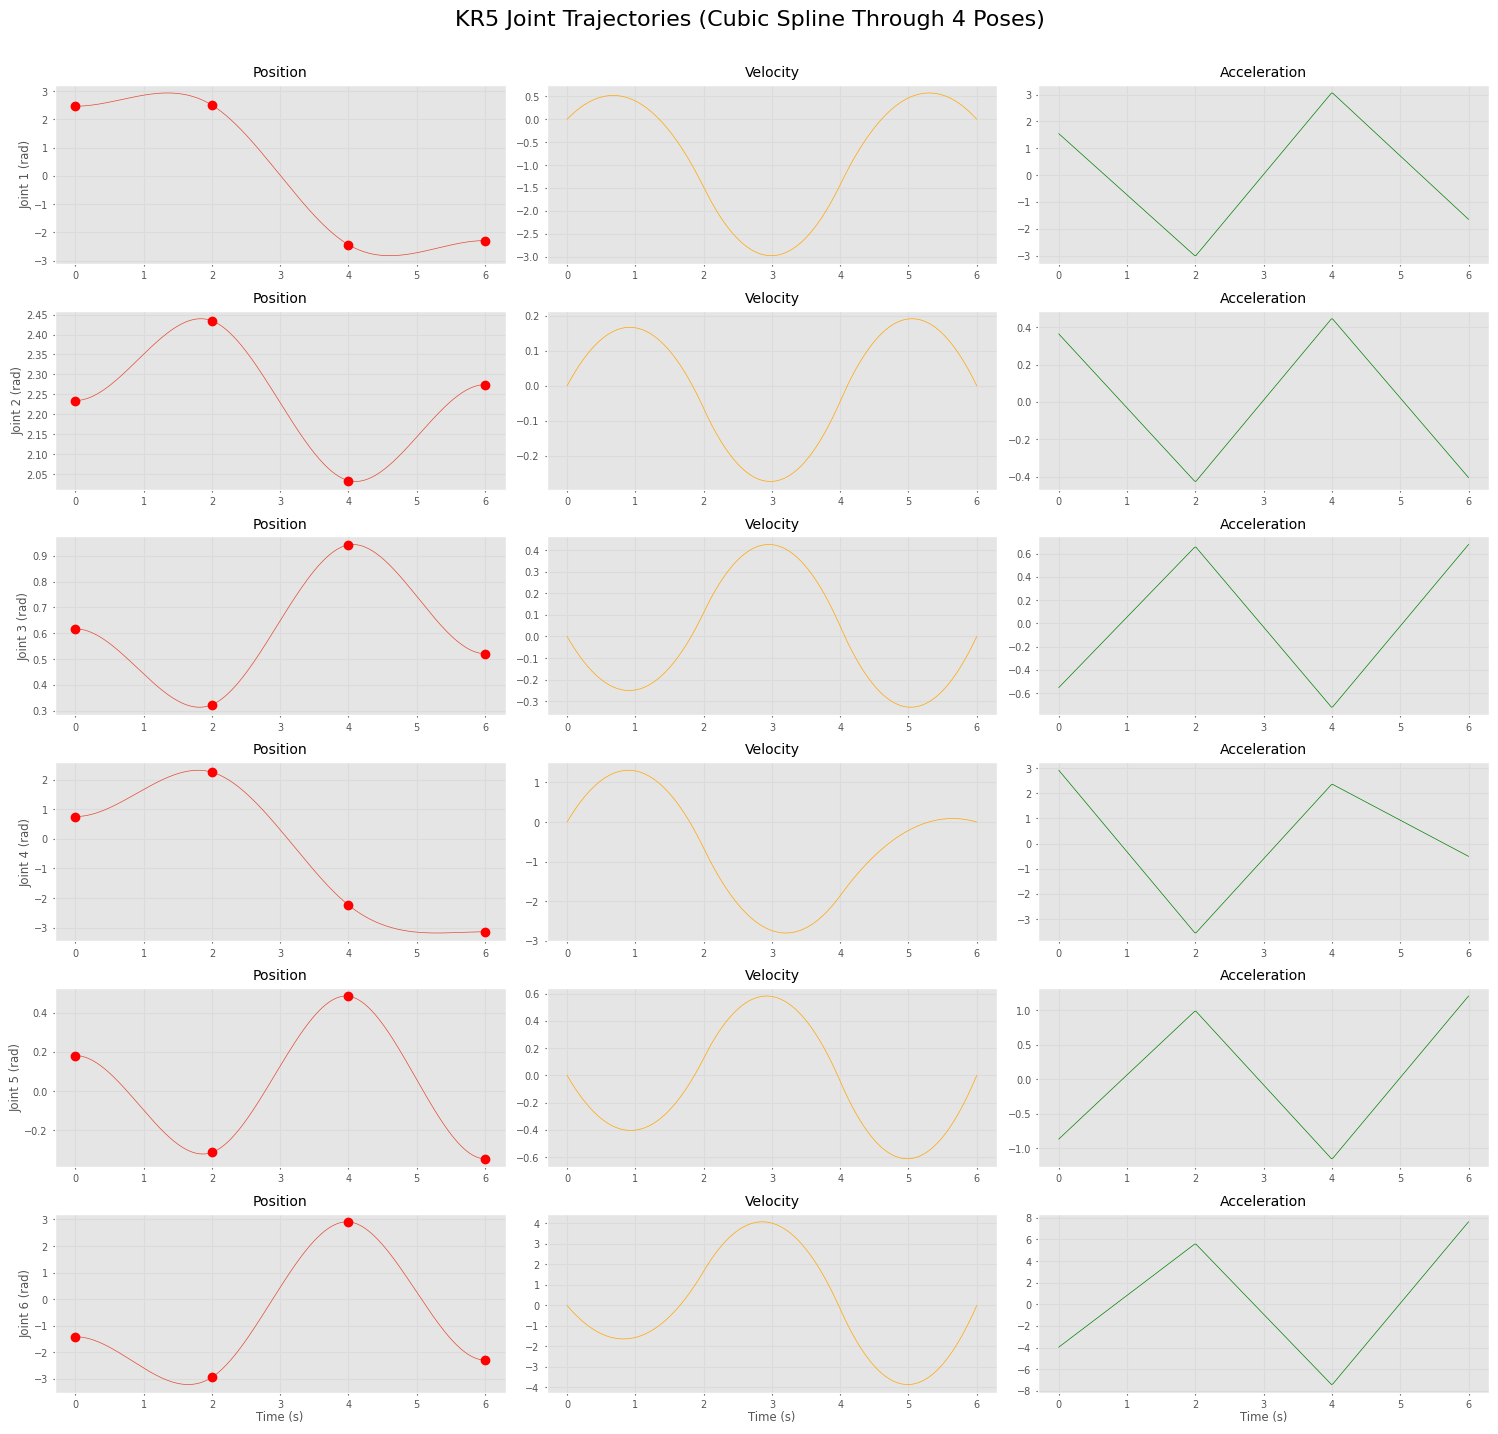

In [18]:
fig, axs = plt.subplots(num_joints, 3, figsize=(15, 2.5 * num_joints))
joint_labels = [f"Joint {j+1}" for j in range(num_joints)]

for j in range(num_joints):
    axs[j, 0].plot(t_total, q_trajectory[j, :], label="Position")
    axs[j, 0].plot(t_points, joint_configs[:, j], 'ro')  # via points
    axs[j, 0].set_ylabel(f'{joint_labels[j]} (rad)')
    axs[j, 0].set_title("Position")
    axs[j, 0].grid(True)

    axs[j, 1].plot(t_total, q_dot_trajectory[j, :], label="Velocity", color='orange')
    axs[j, 1].set_title("Velocity")
    axs[j, 1].grid(True)

    axs[j, 2].plot(t_total, q_ddot_trajectory[j, :], label="Acceleration", color='green')
    axs[j, 2].set_title("Acceleration")
    axs[j, 2].grid(True)

for ax in axs[-1, :]:
    ax.set_xlabel("Time (s)")

plt.suptitle("KR5 Joint Trajectories (Cubic Spline Through 4 Poses)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()